## Import Data

In [1]:
import warnings
warnings.filterwarnings('ignore')
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from error_generator import Random_Active_Domain
from error_generator import List_selected
from error_generator import Read_Write
from error_generator import Error_Generator
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelBinarizer
from sklearn.linear_model import LassoCV
from yellowbrick.regressor import AlphaSelection
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn import linear_model
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from yellowbrick.regressor import PredictionError
from sklearn.preprocessing import OneHotEncoder

## Train-test dataset

In [2]:
anime_train = pd.read_csv("data/trainDataset.csv")
anime_test = pd.read_csv("data/testDataset.csv")

In [3]:
anime_train.head()

,anime_id,name,genre,type,episodes,rating,members,overview
0,12429,Anata ga Furikaeru Toki,"Romance,School,Shoujo",tv series,2,6.56,4621,'Kiteretsu Daihyakka is the story of Eichii Ki...
1,33888,Jubilee,"Comedy,Drama,Fantasy,Music",movie,3,4.67,35,'Queen Elisabeth I travels 400 years into the ...
2,1860,Eiyuu Gaiden Mozaicka,Animation,movie,14,7.31,43632,NaN
3,2848,Sky Girls OVA,"Animation,Short,Sci-Fi",movie,1,7.65,6953,'Earth is at war with aliens. The war has left...
4,22625,Gakuen de Jikan yo Tomare,Hentai,movie,1,6.00,75,"""In order to wish for immortality and avenge h..."


In [4]:
anime_train['genre'].fillna('',  inplace=True)
anime_train['overview'].fillna('',  inplace=True)
anime_train['type'].fillna('',  inplace=True)

In [5]:
anime_test['genre'].fillna('',  inplace=True)
anime_test['overview'].fillna('',  inplace=True)
anime_test['type'].fillna('',  inplace=True)

In [6]:
null_columns = anime_train.columns[anime_train.isnull().any()]
anime_train[null_columns].isnull().sum()

rating    36
dtype: int64

In [7]:
null_columns = anime_test.columns[anime_test.isnull().any()]
anime_test[null_columns].isnull().sum()

rating    5
dtype: int64

## Generating Errors

In [8]:
import random
def error_generator(dataset, n):
    df=dataset.sample(n)
    print(df.loc[df.type == "tv series", 'type'].count())
    print(df.loc[df.type == "movie", 'type'].count())
    print(df.loc[df.type == "", 'type'].count())
    
    df_movie = df.loc[df.type == "movie"]
    for i, row in df_movie.iterrows():
        if row['type'] =="movie":
            df_movie.at[i,'type']= random.choice(['tv series',''])
            
    df_tv = df.loc[df.type == "tv series"]
    for i, row in df_tv.iterrows():
        if row['type'] =="tv series":
            df_tv.at[i,'type']= random.choice(['movie','']) 
            
    df_empty = df.loc[df.type == ""]
    for i, row in df_empty.iterrows():
        if row['type'] =="":
            df_empty.at[i,'type']= random.choice(['tv series','movie'])      

    
    df.update(df_movie.type)
    df.update(df_tv.type)
    df.update(df_empty.type)
    print(df.loc[df.type == "tv series", 'type'].count())
    print(df.loc[df.type == "movie", 'type'].count())
    print(df.loc[df.type == "", 'type'].count())
    
    dataset.update(df.type)
    return dataset

In [9]:
anime_train = error_generator(anime_train, 1200)
anime_train.to_csv("data/dirtyTrainDataset.csv", index = False,
                  columns = ['anime_id', 'name','genre','type', 'episodes','rating', 'members', 'overview'])

593
607
0
275
308
617


In [10]:
anime_train.head()

,anime_id,name,genre,type,episodes,rating,members,overview
0,12429,Anata ga Furikaeru Toki,"Romance,School,Shoujo",tv series,2,6.56,4621,'Kiteretsu Daihyakka is the story of Eichii Ki...
1,33888,Jubilee,"Comedy,Drama,Fantasy,Music",tv series,3,4.67,35,'Queen Elisabeth I travels 400 years into the ...
2,1860,Eiyuu Gaiden Mozaicka,Animation,movie,14,7.31,43632,
3,2848,Sky Girls OVA,"Animation,Short,Sci-Fi",tv series,1,7.65,6953,'Earth is at war with aliens. The war has left...
4,22625,Gakuen de Jikan yo Tomare,Hentai,,1,6.00,75,"""In order to wish for immortality and avenge h..."


In [11]:
null_columns = anime_train.columns[anime_train.isnull().any()]
anime_train[null_columns].isnull().sum()

rating    36
dtype: int64

## Transformation

In [12]:
import nltk
def get_words(x):
    bagofwords=[]
    for i in x:
        if i[1]=='NN':
            bagofwords.append(i[0])
        elif i[1]=='NNS':
            bagofwords.append(i[0])
        elif i[1]=='NNP':
            bagofwords.append(i[0])
        elif i[1]=='NNPS':
            bagofwords.append(i[0])
        elif i[1]=='JJ':
            bagofwords.append(i[0])
        elif i[1]=='JJR':
            bagofwords.append(i[0])
        elif i[1]=='JJS':
            bagofwords.append(i[0])
        elif i[1]=='RB':
            bagofwords.append(i[0])
        elif i[1]=='RBR':
            bagofwords.append(i[0])
        elif i[1]=='RBS':
            bagofwords.append(i[0])
    return bagofwords

def clean_words(x):
    b=nltk.pos_tag(nltk.word_tokenize(x))
    result=get_words(b)
    return result

In [13]:
def get_dummies(train_data_set, test_data_set):
    train_dummies = train_data_set.genre.str.get_dummies(',')
    test_dummies = test_data_set.genre.str.get_dummies(',')
    
    #### ALİGN
    train_dummies, test_dummies = train_dummies.align(test_dummies, axis=1, join='inner')
    
    #reset index
    train_dummies= train_dummies.reset_index()
    test_dummies = test_dummies.reset_index()
    
    train_data_set=train_data_set.reset_index()
    test_data_set=test_data_set.reset_index()
    
    train_data_set = pd.concat([train_data_set, train_dummies ], axis=1)
    test_data_set = pd.concat([test_data_set, test_dummies],  axis=1)
    
    #print("Train with genre",train_data_set.shape)    
    #print("Test with genre",test_data_set.shape)
    
    #test_dummies.fillna(0, inplace=True)
    train_data_set.loc[train_data_set.type == "", 'type']= "tv series"
    test_data_set.loc[test_data_set.type == "", 'type']= "tv series"
    
    type_lb = LabelBinarizer()
    fitted_type_lb = type_lb.fit(train_data_set.type.values)
    X_train = type_lb.transform(train_data_set.type.values)
    X_test  = type_lb.transform(test_data_set.type.values)
    
    dfOneHot_train = pd.DataFrame(X_train, columns = ["movie/TVseries"])
    dfOneHot_test  = pd.DataFrame(X_test,  columns = ["movie/TVseries"])
    
    dfOneHot_train.reset_index()
    dfOneHot_train.reset_index()
    
    #dfOneHot_train = pd.DataFrame(X_train, columns = ["movie/TVseries" for i in range(X_train.shape[1])])
    #dfOneHot_test  = pd.DataFrame(X_test,  columns = ["movie/TVseries" for i in range(X_test.shape[1])])
    
    #print("dfOneHot_train",dfOneHot_train.shape)    
    #print("dfOneHot_test",dfOneHot_test.shape)
    
    #train_data_set = pd.concat([train_data_set, dfOneHot_train], axis=1, join="outer")
    #train_data_set = pd.concat([train_data_set, train_dummies ], axis=1, join="inner")
    train_data_set['movie/TVseries'] = dfOneHot_train
    test_data_set['movie/TVseries'] = dfOneHot_test
    #test_data_set = pd.concat([test_data_set, dfOneHot_test], axis=1, join="outer")
    #test_data_set = pd.concat([test_data_set, test_dummies],  axis=1,  join="inner")
    
    #test_data_set['movie/TVseries'].fillna(0, inplace=True)
    #train_data_set['movie/TVseries'].fillna(0, inplace=True)
    #print("Train with genre and type",train_data_set.shape)    
    #print("Test with genre and type",test_data_set.shape)
    
    
    #null_columns = train_data_set.columns[train_data_set.isnull().any()]
    #print(train_data_set[null_columns].isnull().sum())


    #null_columns = test_data_set.columns[test_data_set.isnull().any()]
    #print(test_data_set[null_columns].isnull().sum())

    return ([train_data_set, test_data_set])

def feature_transformation(train_data_set, test_data_set):
    
    dummieset = get_dummies(train_data_set, test_data_set)
    train_data_set = dummieset[0]
    test_data_set = dummieset[1]
        
    #Bag of Words
    summary_doc_train = train_data_set['overview'].fillna("").map(clean_words)
    summary_doc_train =summary_doc_train.apply(','.join)
    
    summary_doc_test = test_data_set['overview'].fillna("").map(clean_words)
    summary_doc_test =summary_doc_test.apply(','.join)
    
    #print("overview",summary_doc_train.shape)    
    #print("overview",summary_doc_test.shape)
 
    vectorizer = TfidfVectorizer()
    fitted_vectorizer = vectorizer.fit(summary_doc_train)
    overview_feature_train = fitted_vectorizer.transform(summary_doc_train).toarray()
    overview_feature_test = fitted_vectorizer.transform(summary_doc_test).toarray()
    
    df_train = pd.DataFrame(overview_feature_train, columns = ["word"+ str(int(i)) for i in range(overview_feature_train.shape[1])]) 
    
    df_train= df_train.reset_index()
    train_data_set = train_data_set.reset_index()
    train_data_set = pd.concat([train_data_set, df_train], axis=1)
    #print("dataset after add overview",train_data_set.shape) 
   
    df_test = pd.DataFrame(overview_feature_test, columns = ["word"+ str(int(i)) for i in range(overview_feature_test.shape[1])]) 
    df_test= df_test.reset_index()
    test_data_set = test_data_set.reset_index()
    test_data_set = pd.concat([test_data_set, df_test], axis=1)
    #print("dataset after add overview test",test_data_set.shape)
    
    train_data_set = train_data_set.drop(columns=['anime_id', 'name', 'genre', 'overview', 'type'])
    test_data_set = test_data_set.drop(columns=['anime_id', 'name', 'genre', 'overview', 'type'])
    
    #drop NaN values
    #train_data_set.dropna(inplace=True)
    #test_data_set.dropna(inplace=True)
    
    #train_data_set.fillna(0, inplace=True)
    #test_data_set.fillna(0, inplace=True)
    return ([train_data_set, test_data_set])


In [14]:
from sklearn.feature_extraction.text import TfidfVectorizer

# generate features vector
transformed_features = feature_transformation(anime_train, anime_test)
anime_train = transformed_features[0]
anime_test = transformed_features[1]

#print(anime_train.shape)
#print(anime_test.shape)

#print('train before drop \n',anime_train.shape)
#print('test before drop \n',anime_test.shape)

#drop NaN values
anime_train.dropna(inplace=True)
anime_test.dropna(inplace=True)

#print('train after drop \n',anime_train.shape)
#print('test after drop \n',anime_test.shape)

null_columns = anime_train.columns[anime_train.isnull().any()]
#print(anime_train[null_columns].isnull().sum())


null_columns = anime_test.columns[anime_test.isnull().any()]
#rint(anime_test[null_columns].isnull().sum())


In [15]:
# split features vector 
anime_y_train = anime_train['rating']
anime_X_train = anime_train.drop(columns=['rating'])

anime_y_test = anime_test['rating']
anime_X_test = anime_test.drop(columns=['rating'])

## Feature Selection

In [16]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_regression
from sklearn.preprocessing import StandardScaler

selector = SelectKBest(score_func=f_regression,k=700)
features = selector.fit(anime_X_train, anime_y_train)
anime_X_train = features.transform(anime_X_train)
anime_X_test = features.transform(anime_X_test)

scaler = StandardScaler() 

# Apply transform to both the training set and the test set.
anime_X_train = scaler.fit_transform(anime_X_train)  
anime_X_test = scaler.transform(anime_X_test) 


## Training - Testing - Evaluation

In [17]:
def training(model, dataset, label):
    clf = model
    clf.fit(dataset, label)
    return clf

def testing_evaluation(model, testset):
    # Make predictions using the testing set
    anime_y_pred = model.predict(testset)
    
    # The mean squared error
    print("Mean squared error: %.2f" % np.sqrt(mean_squared_error(anime_y_test, anime_y_pred)))

    
    visualizer = PredictionError(model)
    visualizer.fit(anime_X_train, anime_y_train)  # Fit the training data to the visualizer
    visualizer.score(anime_X_test, anime_y_test)  # Evaluate the model on the test data
    g = visualizer.poof() 
    
    
    plt.plot(anime_y_test, '--g', anime_y_pred, '--b')

### Training

Mean squared error: 1.05


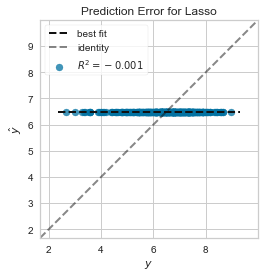

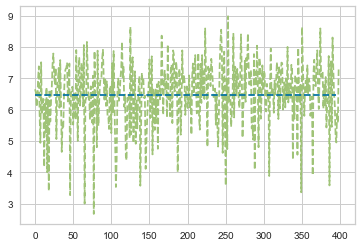

In [18]:
clf = training(model = linear_model.Lasso(), dataset = anime_X_train, label= anime_y_train)
testing_evaluation(clf, anime_X_test)

### Cross Validation

In [19]:
def display_scores(scores):
    print("Scores:", scores)
    print("Mean:", scores.mean())
    print("Standard deviation:", scores.std())
    
scores = cross_val_score(clf, anime_X_train, anime_y_train, scoring="neg_mean_squared_error", cv=5) 
rmse_scores = np.sqrt(-scores)
display_scores(rmse_scores)

Scores: [0.98830377 1.01899653 1.10293231 0.99323579 0.95682162]
Mean: 1.0120580034385127
Standard deviation: 0.04954973214125788


### Grid Search For Hyper Parameter Selection

In [20]:
def checkHP(model, folds, dataset, label):
    parameters = {
                    "alpha" : [1,0.1,0.01,0.001,0.0001,0]
                  }

    gd_sr = GridSearchCV(estimator=model,  
                         param_grid=parameters,
                         scoring="neg_mean_squared_error",
                         cv=folds)

    gd_sr.fit(dataset, label)  
    
    best_parameters = gd_sr.best_params_  
    print("best parameters are: ", best_parameters)

    best_result = gd_sr.best_score_  
    print("The mean squared Error is: %.2f" % -best_result) 
    
checkHP(clf, 5, anime_X_train, anime_y_train) 

best parameters are:  {'alpha': 0.01}
The mean squared Error is: 0.89


c:\users\larat\appdata\local\programs\python\python37-32\lib\site-packages\pattern-3.6-py3.7.egg\pattern\text\en\..\..\..\..\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Mean squared error: 1.04


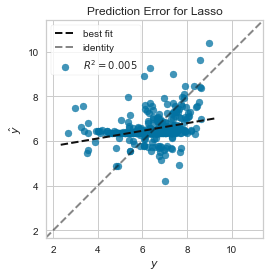

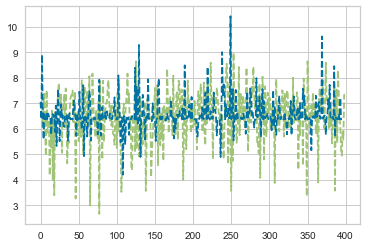

In [21]:
clf = training(model = linear_model.Lasso(alpha = 0.01), dataset = anime_X_train, label= anime_y_train)
testing_evaluation(clf, anime_X_test)